In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

In [2]:
from src.conditional_ngram_models import BigramSpellCorrector, TrigramSpellCorrector
from src.ngram_models import BigramModel, START_TOKEN, END_TOKEN, UNKNOWN_TOKEN, TrigramModel, BaseNgramModel

## The Dataset

In [3]:
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Drogias\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [4]:
movie_corpus = nltk.corpus.movie_reviews.fileids()                                 #Get all the files
movie_corpus

['neg/cv000_29416.txt',
 'neg/cv001_19502.txt',
 'neg/cv002_17424.txt',
 'neg/cv003_12683.txt',
 'neg/cv004_12641.txt',
 'neg/cv005_29357.txt',
 'neg/cv006_17022.txt',
 'neg/cv007_4992.txt',
 'neg/cv008_29326.txt',
 'neg/cv009_29417.txt',
 'neg/cv010_29063.txt',
 'neg/cv011_13044.txt',
 'neg/cv012_29411.txt',
 'neg/cv013_10494.txt',
 'neg/cv014_15600.txt',
 'neg/cv015_29356.txt',
 'neg/cv016_4348.txt',
 'neg/cv017_23487.txt',
 'neg/cv018_21672.txt',
 'neg/cv019_16117.txt',
 'neg/cv020_9234.txt',
 'neg/cv021_17313.txt',
 'neg/cv022_14227.txt',
 'neg/cv023_13847.txt',
 'neg/cv024_7033.txt',
 'neg/cv025_29825.txt',
 'neg/cv026_29229.txt',
 'neg/cv027_26270.txt',
 'neg/cv028_26964.txt',
 'neg/cv029_19943.txt',
 'neg/cv030_22893.txt',
 'neg/cv031_19540.txt',
 'neg/cv032_23718.txt',
 'neg/cv033_25680.txt',
 'neg/cv034_29446.txt',
 'neg/cv035_3343.txt',
 'neg/cv036_18385.txt',
 'neg/cv037_19798.txt',
 'neg/cv038_9781.txt',
 'neg/cv039_5963.txt',
 'neg/cv040_8829.txt',
 'neg/cv041_22364.txt',


In [5]:
combined_text = ""             
for file_id in movie_corpus:                                        # Combine the text from all files
    combined_text += nltk.corpus.movie_reviews.raw(file_id)

print(combined_text[:500])

plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt


In [6]:
combined_text = combined_text.lower()                              #Convert to lowercase

In [7]:
combined_text[:500]

'plot : two teen couples go to a church party , drink and then drive . \nthey get into an accident . \none of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . \nwhat\'s the deal ? \nwatch the movie and " sorta " find out . . . \ncritique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . \nwhich is what makes this review an even harder one to write , since i generally applaud films which attempt'

In [8]:
import re

def remove_special_chars(text):
   text = text.replace('[', '')
   text = text.replace(']', '')
   text = text.replace('\n', ' ')
   text = re.sub(r'[^a-zA-z.?!\']', ' ', text)                     #Remove these characters   

   return text

In [9]:
combined_text = remove_special_chars(combined_text)
combined_text[:500]

"plot   two teen couples go to a church party   drink and then drive .  they get into an accident .  one of the guys dies   but his girlfriend continues to see him in her life   and has nightmares .  what's the deal ?  watch the movie and   sorta   find out . . .  critique   a mind fuck movie for the teen generation that touches on a very cool idea   but presents it in a very bad package .  which is what makes this review an even harder one to write   since i generally applaud films which attempt"

In [10]:
len(combined_text.split())                     

1375247

In [11]:
len(combined_text)                             # How many characters

7785824

In [12]:
combined_text[11792000:]

''

In [13]:
def tokenize_sentences(text):
    sentences = nltk.sent_tokenize(''.join(text))                  #Get the sentences
    return sentences     

In [14]:
sentences = tokenize_sentences(combined_text) 
print(len(sentences))    
print(sentences[2])  
print(sentences[57649])

71360
one of the guys dies   but his girlfriend continues to see him in her life   and has nightmares .
that's okay   because director john mcnaughton knows that he's making a self consciously wicked film .


In [15]:
def tokenize_words(text):
    words = nltk.word_tokenize(text)
    return words

In [16]:
words = tokenize_words(combined_text)
print(len(words))
print(words[3])
print(words[-2])

1405016
couples
be


In [17]:
words_list = []                                    #list of all the words of sentences
for f in sentences:
    words_list.append(tokenize_words(f))                   

In [18]:
len(words_list)

71360

In [19]:
for word in words_list[1]:                     # all the words of the second sentence
    print(word) 

they
get
into
an
accident
.


In [20]:
import random
import math


random.shuffle(words_list)
train_len = math.floor(0.6 * len(words_list))                      #Training set length(60%)
dev_len = math.floor(0.2 * len(words_list))                        #Development set length (20%)
test_len = math.floor(0.2 * len(words_list))                       #Test set length (20%)

training_set = []
development_set = []
test_set = []

for content in words_list[0:train_len]:
    training_set.append(content)
    
for content in words_list[train_len: train_len + dev_len]:
    development_set.append(content)

for content in words_list[train_len + dev_len:]:
    test_set.append(content)

In [21]:
import itertools
from collections import Counter

from nltk.util import ngrams


def _calc_ngrams(all_corpus: list[str], ngram: int) -> Counter:
    """
    Process a tokenized sentence into a list of ngrams.
    :param all_corpus: a list of all the corpus words
    :param ngram: whether the ngrams will be unigrams, bigrams etc
    :return: the counter of either unigram, bigram or trigram
    """
    unigram_counter = Counter()
    bigram_counter = Counter()
    trigram_counter = Counter()
     
    

    if ngram == 1 :
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             unigram_counter.update(grams)
        return unigram_counter
        
    elif ngram == 2:
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             bigram_counter.update(grams)
        return bigram_counter
        
    elif ngram == 3:
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             trigram_counter.update(grams)
        return trigram_counter
        
    return 0

In [22]:
def replace_OOV_words_train(all_corpus):
    unigram_counter = _calc_ngrams(all_corpus,1)
    OOV_words = {}

    for k, v in unigram_counter.items():
        if v < 10:
            key = k[0]
            # README: Use the symbol UNKOWN_TOKEN else the model will think it's a word
            OOV_words[key] = UNKNOWN_TOKEN                 #set the word to "UNK"

    replaced_corpus = []                          #the original corpus having the OOV words replaced by 'UNK'
    for sentence in all_corpus:
        clean_sentence = []
    
        for word in sentence:
            clean_sentence.append(OOV_words.get(word, word))
    
        replaced_corpus.append(clean_sentence)


    vocabulary = []

    for key in unigram_counter.keys():        #Iterate the unigram counter
        word = key[0]                         #get the word
        if word not in OOV_words:
            vocabulary.append(word)

    vocabulary = set(vocabulary)              #Keep unique words
    return vocabulary, replaced_corpus, OOV_words

In [23]:
def replace_OOV_words_test(all_corpus, vocabulary, oov_words):
    
    replaced_corpus = []
    for sentence in all_corpus:
        updated_sent = []

        for word in sentence:
            if (word not in vocabulary) or (word in oov_words):
                updated_sent.append(UNKNOWN_TOKEN)
            else:
                updated_sent.append(word)
                
    replaced_corpus.append(updated_sent)
    return replaced_corpus   

In [24]:
vocabulary, train_corpus, OOV_words = replace_OOV_words_train(training_set)
development_set = replace_OOV_words_test(development_set, vocabulary, OOV_words)
test_set = replace_OOV_words_test(test_set, vocabulary, OOV_words)

In [25]:
vocab_len = len(vocabulary)
print ("Vocabulary length: ", vocab_len)

print("Unigram's 20 most common words:")
unigram_top_20 = _calc_ngrams(train_corpus, 1).most_common(20)
for gram in unigram_top_20:
    print(gram)

print("\n")
print("Bigram's 20 most common words:")
bigram_top_20 = _calc_ngrams(train_corpus,2).most_common(20)
for gram in bigram_top_20:
    print(gram)


print("\n")
print("Trigram's 20 most common words:")
trigram_top_20 = _calc_ngrams(train_corpus,3).most_common(20)
for gram in trigram_top_20:
    print(gram)

Vocabulary length:  6639
Unigram's 20 most common words:
(('<UNK>',), 65268)
(('the',), 45908)
(('.',), 39476)
(('a',), 22729)
(('and',), 21371)
(('of',), 20483)
(('to',), 19192)
(('is',), 15561)
(('in',), 12954)
(("'s",), 10912)
(('it',), 9731)
(('that',), 9529)
(('as',), 6869)
(('with',), 6562)
(('for',), 5920)
(('his',), 5818)
(('this',), 5781)
(('film',), 5719)
(('i',), 5263)
(('he',), 5261)


Bigram's 20 most common words:
(('.', '<end>'), 39428)
(('<UNK>', '<UNK>'), 7384)
(('<UNK>', '.'), 5469)
(('the', '<UNK>'), 5427)
(('of', 'the'), 5300)
(('<start>', 'the'), 4852)
(('<UNK>', 'and'), 3967)
(('in', 'the'), 3463)
(('a', '<UNK>'), 3265)
(('the', 'film'), 2741)
(('and', '<UNK>'), 2659)
(('<UNK>', 'of'), 2393)
(('?', '<end>'), 2302)
(('it', "'s"), 2257)
(('<start>', '<UNK>'), 2169)
(('<UNK>', 'the'), 2084)
(('of', '<UNK>'), 1988)
(('<start>', '.'), 1982)
(('<start>', 'it'), 1872)
(('to', '<UNK>'), 1723)


Trigram's 20 most common words:
(('.', '<end>', '<end>'), 39428)
(('<UNK>', '.

In [26]:
from nltk.tokenize import sent_tokenize, TweetTokenizer


UNK_sentences = [sent_tokenize(' '.join(sentence)) for sentence in train_corpus]       #get the sentences that include UNK values
tweet_wt = TweetTokenizer()
tokenized = [tweet_wt.tokenize(' '.join(sentence)) for sentence in UNK_sentences[:50]]  # Get the first 50 sentences

##  Calculate bi-gram probability

### $ P(w_2|w_1) = \frac{C(w_1,w_2) + \alpha}{C(w_1) + \alpha \cdot|V|} $

* $ C(w_1,w_2) $ : bigram count
* $ C(w_1) $ : unigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter
* |V|: vocabulary size

## Bi-gram LM Cross entropy & perplexity

* $ CrossEntropy = -\frac{1}{N}\sum^{bigrams}{log_2(P(w_2|w_1))} $
 * N: Number of bigrams
* $ Perplexity = 2^{H(p)} $

## Tri-gram LM Cross entropy & perplexity

### $ P(w_3|w_1,w_2) = \frac{C(w_1,w_2,w_3) + \alpha}{C(w_1,w_2) + \alpha \cdot |V|} $

* $ C(w_1,w_2,w_3) $ : trigram count
* $ C(w_1,w_2) $ : bigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter
* |V|: vocabulary size

In [27]:
def cross_entropy(model: BaseNgramModel, dataset: list[list[str]]) -> float:
    """
    Calculate the cross-entropy of a language model on a given dataset.
    
    Cross-entropy measures how well the language model predicts the given dataset.
    Lower cross-entropy indicates better model performance.
    
    :param model: The n-gram language model for which cross-entropy is calculated.
    :param dataset: The dataset as a list of tokenized sentences, where each sentence is a list of strings.
    :return: The cross-entropy score as a float.
             Lower values indicate better performance in predicting the dataset.
    """
    # since la place smoothing is only involved during inference
    # we don't need to refit the model
    sum_prob = 0
    word_count = 0
    
    for sentence in dataset:       
        # since this is a full sentence we manually append the end token
        sentence += [END_TOKEN]
        
        # take into account only the END_TOKEN since START token probs are not computed
        word_count += len(sentence)
        
        # get sentence probability
        sum_prob += bi_model.sentence_proba(sentence) 
    
    # do we need to logarithmize this again?
    return - sum_prob / word_count


def perplexity(cross_entropy: float) -> float:
    """
    Calculate perplexity from cross-entropy.
    
    Perplexity is a measure of how well the language model predicts the given dataset.
    A model with a perplexity of k, has approximately a 1/k chance of correctly predicting the next word in a sentence.
    
    :param cross_entropy: The cross-entropy score calculated for a language model on a dataset.
    :return: The perplexity score as a float.
             Lower values indicate better performance in predicting the dataset.
    """
    return 2**cross_entropy

In [28]:
def plot_alpha_vs_entropy(alpha_values, entropy, best_index):
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, entropy, marker='o', linestyle='-', color='b')
    plt.title('Alpha vs Entropy')
    plt.xlabel('Alpha Values')
    plt.ylabel('Cross Entropy')
    plt.grid(True)
    
    # Highlight the best alpha value
    plt.scatter(alpha_values[best_index], entropy[best_index], color='r', marker='x', label='Best Alpha')
    
    plt.legend()
    plt.show()


In [29]:
def ngram_model_alpha_search(fitted_model: BaseNgramModel, 
                             alpha_values: np.ndarray, 
                             validation_dataset: list[list[str]]) -> float:
    entropy_arr = np.full_like(alpha_values, np.inf)
    
    for i in range(len(alpha_values)):
        fitted_model.alpha = alpha_values[i]
        entropy_arr[i] = cross_entropy(fitted_model, validation_dataset)
        
       
    best_index = np.argmin(entropy_arr)
    plot_alpha_vs_entropy(alpha_values,entropy_arr, best_index) 
    return alpha_values[best_index]

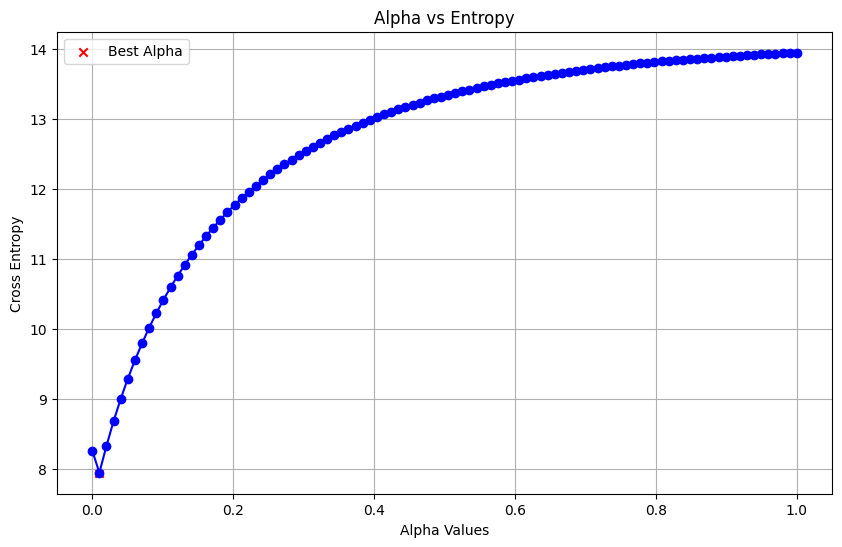

Optimal alpha (bigram model):  0.010199999999999999


In [30]:
bi_model = BigramModel(alpha=0.001)
bi_model.fit(train_corpus)

bi_opt_alpha = ngram_model_alpha_search(bi_model, np.linspace(0.0001, 1, 100), development_set)
print("Optimal alpha (bigram model): ", bi_opt_alpha)

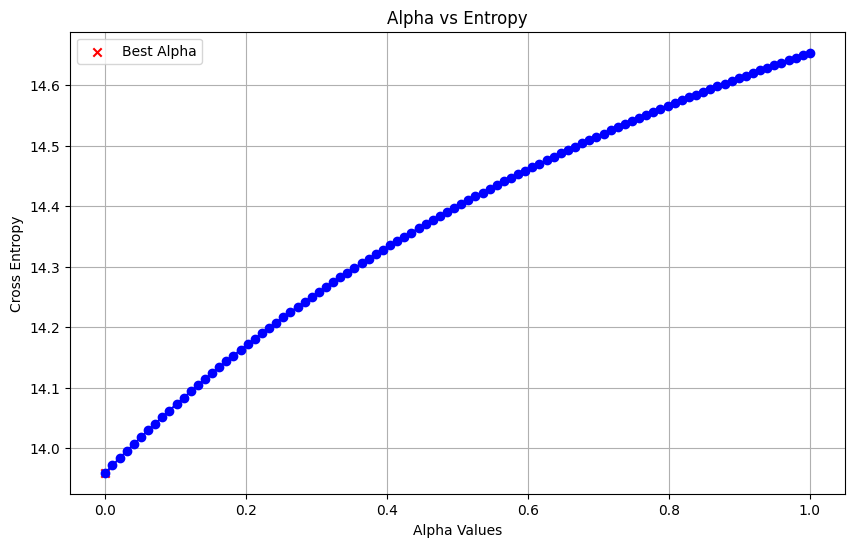

Optimal alpha (trigram model):  0.0001


In [31]:
tri_model = TrigramModel(alpha=0.001)
tri_model.fit(train_corpus)

tri_opt_alpha = ngram_model_alpha_search(tri_model, np.linspace(0.0001, 1, 100), development_set)
print("Optimal alpha (trigram model): ", tri_opt_alpha)

Now, let's test the performance in the test set, after having defined the optimal alpha.

In [32]:
# since la place smoothing is only involved during inference
# we don't need to refit the model
bi_model.alpha = bi_opt_alpha

bi_hc = cross_entropy(bi_model, test_set)
print(f"Bi-gram model Cross Entropy: {bi_hc:.2f}", )
print(f"Bi-gram model Perplexity: {perplexity(bi_hc):2f}")

Bi-gram model Cross Entropy: 6.43
Bi-gram model Perplexity: 86.304868


In [33]:
tri_model.alpha = tri_opt_alpha

tri_hc = cross_entropy(tri_model, test_set)
print(f"Tri-gram model Cross Entropy: {tri_hc:.2f}")
print(f"Tri-gram model Perplexity: {perplexity(tri_hc):.2f}")

Tri-gram model Cross Entropy: 7.30
Tri-gram model Perplexity: 157.20


In [34]:
max_depth = 5
beam_width = 3

v. Create a fake dataset

In [35]:
import random


def corrupt_sentence(sentence, probability):
    corrupted_sentence = ""
    for char in sentence:
        if char != ' ' and random.random() < probability:
            
            corrupted_sentence += get_similar_char(char)                 #replace with a similar character
        else:
            corrupted_sentence += char
    return corrupted_sentence


def get_similar_char(char):
    # later on maybe use the nlpaug library here 
    similar_chars = {
        'a': 'e',
        'b': 'p',
        'c': 's',
        'd': 'b',
        'e': 'a',
        'f': 't',
        'g': 'j',
        'h': 'n',
        'i': 'l',
        'j': 'g',
        'k': 'x',
        'l': 'i',
        'm': 'n',
        'n': 'm',
        'o': 'u',
        'p': 'b',
        'q': 'g',
        'r': 't',
        's': 'c',
        't': 'f',
        'u': 'o',
        'v': 'w',
        'w': 'v',
        'x': 'k',
        'y': 'v',
        'z': 's',
    }
    
    return similar_chars.get(char, char)                            #return a randomly chosen character

In [36]:
probability = 0.1                                        #probability of character replacement
corrupted_corpus = [[corrupt_sentence(word, probability) for word in sentence] for sentence in UNK_sentences]   #generate the corrupted corpus
corrupted_tokenized = [tweet_wt.tokenize(sentence) for sentence_list in corrupted_corpus for sentence in sentence_list] #tokenize the corrupted sentences

for original, corrupted in zip(UNK_sentences[:5], corrupted_corpus[:5]):
    print(f"Original: {original}")
    print(f"Corrupted: {corrupted}")
    print("\n---\n")

Original: ['<UNK> finds out that <UNK> is the <UNK> by wearing the <UNK> around her neck but she ends up falling in love with him .']
Corrupted: ['<UNK> finds out that <UNK> is the <UNK> by wearing the <UNK> around her neck bot sha ends up falling in luve with nim .']

---

Original: ["since mulan 's father is <UNK> but proud the high spirited mulan steals her father 's armor and <UNK> signs up to face the <UNK> menace ."]
Corrupted: ["simca mulam 's fatnar is <UNK> but proud the high spirited muian stealc het father 's arnor and <UNK> sigms up to face tha <UNK> menace ."]

---

Original: ['this film <UNK> me for the simple reason that while it has a fairy tale concept the rest of the film takes itself seriously enough and presents itself well enough to make it more of an american folk tale with characters who are both icons and real people at the same time .']
Corrupted: ['fhis filn <UNK> me for fne simple raason that while it nas a fairy tale concept fhe rest of tne film takec ltself

In [37]:
from tqdm import tqdm


corrected = []
corrector = BigramSpellCorrector(bi_model, lamda=0.1)
for sent in tqdm(corrupted_tokenized[:3]):
  output_seq = corrector.spell_correct(original_tokenized_sentence=sent, beam_width = 3)  #give the corrupt sentences to spell correct
  corrected.append(output_seq)
    
print('Original sentences:', UNK_sentences[:5])
print('\n')
print('Corrupted(wrong) sentences:', corrupted_corpus[:5])
print('\n')
print('Final result (corrected sentences):', corrected[:5])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.42s/it]

Original sentences: [['<UNK> finds out that <UNK> is the <UNK> by wearing the <UNK> around her neck but she ends up falling in love with him .'], ["since mulan 's father is <UNK> but proud the high spirited mulan steals her father 's armor and <UNK> signs up to face the <UNK> menace ."], ['this film <UNK> me for the simple reason that while it has a fairy tale concept the rest of the film takes itself seriously enough and presents itself well enough to make it more of an american folk tale with characters who are both icons and real people at the same time .'], ['adapted from the stage play by john cameron mitchell and stephen <UNK> .'], ['that to me is what makes a dog of <UNK> all the more delightful .']]


Corrupted(wrong) sentences: [['<UNK> finds out that <UNK> is the <UNK> by wearing the <UNK> around her neck bot sha ends up falling in luve with nim .'], ["simca mulam 's fatnar is <UNK> but proud the high spirited muian stealc het father 's arnor and <UNK> sigms up to face tha <U

In [38]:
import jiwer

def calculate_wer_cer(original_sentences, corrected_sentences):
    wer_sum = 0
    cer_sum = 0
    total_sentences = len(original_sentences)

    for original, corrected in zip(original_sentences, corrected_sentences):
        wer = jiwer.wer(original, corrected)
        wer_sum += wer

        
        cer = jiwer.cer(original, corrected)
        cer_sum += cer

    
    avg_wer = wer_sum / total_sentences
    avg_cer = cer_sum / total_sentences

    return avg_wer, avg_cer



avg_wer, avg_cer = calculate_wer_cer(tokenized, corrected)

print(f"Average Word Error Rate (WER): {avg_wer}")
print(f"Average Character Error Rate (CER): {avg_cer}")

Average Word Error Rate (WER): 0.01240598568640208
Average Character Error Rate (CER): 0.01427814001188614
